Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = ""
ID = ""

---

### SVM supplementary example

In this example we will implement SVM classification using linear and Gaussian kernel.

This example has been adapted from <a herf="https://pythonprogramming.net/soft-margin-kernel-cvxopt-svm-machine-learning-tutorial/">pythonprogramming.net</a>

In [1]:
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
import pylab as pl

Define linear, polynomial and Gaussian kernel.

In [2]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

Define **fit** function to implement cvxopt using linear, polynomial and Gaussian kernel. 

Here the C hyperparameter controls the level of misclassification in SVM optimization. So the C hypermeter which is set before the training model and used to control error, a very small value of C will cause the optimizer to look for a larger-margin (soft margin) separating hyperplane, even if that hyperplane misclassifies more datapairs.

Here **a** are the Lagrange multipliers and **sv** are the support vectors.


In [3]:

def fit(X, y, kernel, C):
    n_samples, n_features = X.shape

    # Gram matrix
    # initialize kernel matrix    
    K = np.zeros((n_samples, n_samples))
    # Kernel matrix
    
    for i in range(n_samples):
        for j in range(n_samples):
            if kernel == 'linear_kernel':
                K[i,j] = linear_kernel(X[i], X[j])
            elif kernel == 'polynomial_kernel':
                K[i,j] = polynomial_kernel(X[i], X[j])
            else:
                K[i,j] = gaussian_kernel(X[i], X[j])
            
     
    P = cvxopt.matrix(np.outer(y,y) * K)
    q = cvxopt.matrix(np.ones(n_samples) * -1)
    A = cvxopt.matrix(y, (1,n_samples))
    b = cvxopt.matrix(0.0)

    if C is None:
        G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        h = cvxopt.matrix(np.zeros(n_samples))
    else:
        tmp1 = np.diag(np.ones(n_samples) * -1)
        tmp2 = np.identity(n_samples)
        G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
        tmp1 = np.zeros(n_samples)
        tmp2 = np.ones(n_samples) * C
        h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

    # solve QP problem
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)

    # Lagrange multipliers
    a = np.ravel(solution['x'])

    # Support vectors have non zero lagrange multipliers
    sv_idx = a > 1e-5
    ind = np.arange(len(a))[sv_idx]
    a = a[sv_idx]    
    sv = X[sv_idx]
    sv_y = y[sv_idx]
    print("%d support vectors out of %d points" % (len(a), n_samples))

    # Intercept
    b = 0
    for n in range(len(a)):
        b += sv_y[n]
        b -= np.sum(a * sv_y * K[ind[n],sv_idx])
    b /= len(a)

    # Weight vector
    if kernel == 'linear_kernel':
        w = np.zeros(n_features)
        for n in range(len(a)):
            w += a[n] * sv_y[n] * sv[n]
    else:
        w = None
    return sv, sv_y, a, w, b


 Define **project** and **predict** function.

In [4]:
def project(X, kernel,sv, sv_y, a, w, b):
    if w is not None:
        return np.dot(X, w) + b
    else:
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            s = 0
            for a_val, sv_y_val, sv_val in zip(a, sv_y, sv):
                if kernel == 'polynomial_kernel':
                    s += a_val * sv_y_val * polynomial_kernel(X[i], sv_val)
                else:
                    s += a_val * sv_y_val * gaussian_kernel(X[i], sv_val)
            y_predict[i] = s
        return y_predict + b

def predict(X, kernel, sv, sv_y, a, w, b):
    return np.sign(project(X, kernel,sv, sv_y, a, w, b))


In [5]:
def gen_lin_separable_data():
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[0.8, 0.6], [0.6, 0.8]])
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

def gen_non_lin_separable_data():
    mean1 = [-1, 2]
    mean2 = [1, -1]
    mean3 = [4, -4]
    mean4 = [-4, 4]
    cov = [[1.0,0.8], [0.8, 1.0]]
    X1 = np.random.multivariate_normal(mean1, cov, 50)
    X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 50)
    X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

def gen_lin_separable_overlap_data():
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[1.5, 1.0], [1.0, 1.5]])
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

In [6]:
def split_train(X1, y1, X2, y2):
    X1_train = X1[:90]
    y1_train = y1[:90]
    X2_train = X2[:90]
    y2_train = y2[:90]
    X_train = np.vstack((X1_train, X2_train))
    y_train = np.hstack((y1_train, y2_train))
    return X_train, y_train

def split_test(X1, y1, X2, y2):
    X1_test = X1[90:]
    y1_test = y1[90:]
    X2_test = X2[90:]
    y2_test = y2[90:]
    X_test = np.vstack((X1_test, X2_test))
    y_test = np.hstack((y1_test, y2_test))
    return X_test, y_test

In [7]:
def plot_margin(X1_train, X2_train, w, b, sv):
    def f(x, w, b, c=0):
        # given x, return y such that [x,y] in on the line
        # w.x + b = c
        return (-w[0] * x - b + c) / w[1]

    pl.plot(X1_train[:,0], X1_train[:,1], "ro")
    pl.plot(X2_train[:,0], X2_train[:,1], "bo")
    pl.scatter(sv[:,0], sv[:,1], s=100, c="g")

    # w.x + b = 0
    a0 = -4; a1 = f(a0, w, b)
    b0 = 4; b1 = f(b0, w, b)
    pl.plot([a0,b0], [a1,b1], "k")

    # w.x + b = 1
    a0 = -4; a1 = f(a0, w, b, 1)
    b0 = 4; b1 = f(b0, w, b, 1)
    pl.plot([a0,b0], [a1,b1], "k--")

    # w.x + b = -1
    a0 = -4; a1 = f(a0, w, b, -1)
    b0 = 4; b1 = f(b0, w, b, -1)
    pl.plot([a0,b0], [a1,b1], "k--")

    pl.axis("tight")
    pl.show()


In [8]:
def plot_contour(X1_train, X2_train, kernel, sv, sv_y, a, w, b):
    pl.plot(X1_train[:,0], X1_train[:,1], "ro")
    pl.plot(X2_train[:,0], X2_train[:,1], "bo")
    pl.scatter(sv[:,0], sv[:,1], s=100, c="g")
    # here we choose the range between -7 and 7 as we have choosen
    # the mean to be between -4 and 4 while generating data with the variance of 0.8
    X1, X2 = np.meshgrid(np.linspace(-7,7,50), np.linspace(-7,7,50))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = project(X, kernel,sv, sv_y, a, w, b).reshape(X1.shape)
    pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

    pl.axis("tight")
    pl.show()

In [9]:
def test_linear():
    X1, y1, X2, y2 = gen_lin_separable_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    kernel = 'linear_kernel'
    C = None
    sv, sv_y, a, w, b = fit(X_train, y_train,kernel, C)

    y_predict = predict(X_test,kernel,sv, sv_y, a, w, b)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_margin(X_train[y_train==1], X_train[y_train==-1], w, b, sv)

def test_non_linear():
    X1, y1, X2, y2 = gen_non_lin_separable_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    kernel = 'gaussian_kernel'
    C = None
    sv, sv_y, a, w, b = fit(X_train, y_train,kernel, C)
    y_predict = predict(X_test,kernel,sv, sv_y, a, w, b)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_contour(X_train[y_train==1], X_train[y_train==-1], kernel, sv, sv_y, a, w, b)

def test_soft():
    X1, y1, X2, y2 = gen_lin_separable_overlap_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    kernel = 'linear_kernel'
    C=1000.1
    sv, sv_y, a, w, b = fit(X_train, y_train,kernel, C)
    y_predict = predict(X_test,kernel,sv, sv_y, a, w, b)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_contour(X_train[y_train==1], X_train[y_train==-1], kernel, sv, sv_y, a, w, b)


     pcost       dcost       gap    pres   dres
 0: -1.6734e+01 -3.1616e+01  5e+02  2e+01  2e+00
 1: -2.1693e+01 -1.3922e+01  2e+02  6e+00  5e-01
 2: -8.8523e+01 -3.3934e+01  1e+02  4e+00  3e-01
 3: -6.6204e+00 -6.5642e+00  2e+01  3e-01  3e-02
 4: -5.0797e+00 -5.4988e+00  5e-01  2e-03  2e-04
 5: -5.4510e+00 -5.4553e+00  5e-03  2e-05  2e-06
 6: -5.4547e+00 -5.4548e+00  5e-05  2e-07  2e-08
 7: -5.4548e+00 -5.4548e+00  5e-07  2e-09  2e-10
Optimal solution found.
3 support vectors out of 180 points
20 out of 20 predictions correct


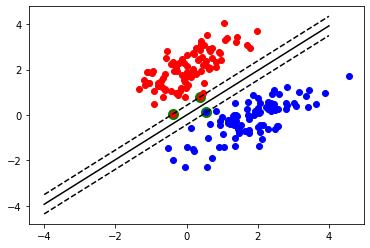

In [10]:
test_linear()

     pcost       dcost       gap    pres   dres
 0: -5.3158e+01 -1.5986e+02  5e+02  2e+01  2e+00
 1: -8.0171e+01 -1.9898e+02  2e+02  6e+00  7e-01
 2: -1.3004e+02 -2.4458e+02  2e+02  5e+00  5e-01
 3: -1.8258e+02 -2.9328e+02  1e+02  1e+00  2e-01
 4: -1.9672e+02 -2.8531e+02  1e+02  9e-01  1e-01
 5: -2.2745e+02 -2.6057e+02  4e+01  2e-01  3e-02
 6: -2.4213e+02 -2.5281e+02  1e+01  3e-02  4e-03
 7: -2.4881e+02 -2.5108e+02  2e+00  2e-13  5e-14
 8: -2.5084e+02 -2.5091e+02  7e-02  6e-14  5e-14
 9: -2.5090e+02 -2.5090e+02  9e-04  3e-13  5e-14
10: -2.5090e+02 -2.5090e+02  9e-06  3e-13  5e-14
Optimal solution found.
9 support vectors out of 180 points
20 out of 20 predictions correct


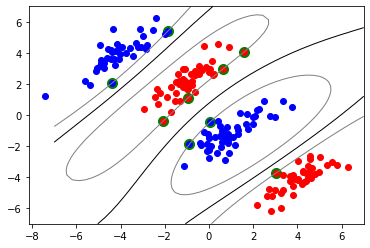

In [11]:
test_non_linear()

     pcost       dcost       gap    pres   dres
 0:  1.3686e+05 -9.1659e+07  2e+08  6e-01  5e-12
 1:  3.8291e+05 -1.6472e+07  3e+07  4e-02  2e-11
 2:  3.1119e+05 -3.4262e+06  5e+06  7e-03  5e-12
 3:  8.1425e+04 -5.2398e+05  6e+05  1e-04  2e-12
 4:  1.4258e+03 -7.9740e+04  8e+04  8e-06  1e-12
 5: -3.3090e+03 -9.4041e+03  6e+03  5e-07  1e-12
 6: -5.5491e+03 -9.9588e+03  4e+03  6e-08  2e-12
 7: -5.4606e+03 -9.7088e+03  4e+03  5e-08  2e-12
 8: -5.7679e+03 -9.1139e+03  3e+03  2e-08  3e-12
 9: -6.0310e+03 -7.7321e+03  2e+03  5e-09  3e-12
10: -6.0418e+03 -7.4414e+03  1e+03  3e-09  3e-12
11: -6.1327e+03 -6.9325e+03  8e+02  1e-09  2e-12
12: -6.2774e+03 -6.7607e+03  5e+02  8e-11  3e-12
13: -6.3506e+03 -6.6529e+03  3e+02  4e-11  2e-12
14: -6.3649e+03 -6.6416e+03  3e+02  3e-11  2e-12
15: -6.3853e+03 -6.5877e+03  2e+02  1e-11  2e-12
16: -6.4600e+03 -6.4766e+03  2e+01  4e-13  3e-12
17: -6.4661e+03 -6.4663e+03  3e-01  2e-13  3e-12
18: -6.4662e+03 -6.4662e+03  3e-03  7e-13  3e-12
Optimal solution foun

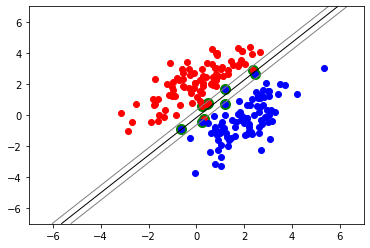

In [12]:
test_soft()